# Amazon Review Rating Prediction

The project deals with the analysis of customer reviews on eCommerce platforms, specifically for consumer electronics. The objective is to build an end-to-end Machine Learning model that predicts review ratings based on review contents and metadata. We have identified a dataset of 100,000 Amazon product reviews that can be used for model training and then need to deploy the model to an endpoint.


## Environment setup

In [66]:
# load necessary modules
import pickle, re, requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import metrics

In [67]:
nltk.download("stopwords", quiet = True)
nltk.download("wordnet", quiet = True)
nltk.download("punkt", quiet = True)
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

## Dataset Overview
Our dataset is included in the tab-delimited file `amazon_reviews.tsv`. Here is a brief description of the dataframe columns:

<br>

| Column name 	| Description 	|
|-	|-	|
| marketplace 	| 2 letter country code of the marketplace where the review was written. 	|
| customer_id 	| Random identifier that can be used to aggregate reviews written by a single author. 	|
| review_id 	| The unique ID of the review. 	|
| product_id 	| The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id. 	|
| product_parent 	| Random identifier that can be used to aggregate reviews for the same product. 	|
| product_title 	| Title of the product. 	|
| product_category 	| Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). 	|
| helpful_votes 	| Number of helpful votes. 	|
| total_votes 	| Number of total votes the review received. 	|
| vine 	| Review was written as part of the Vine program. 	|
| verified_purchase 	| The review is on a verified purchase. 	|
| review_headline 	| The title of the review. 	|
| review_body 	| The review text. 	|
| review_date 	| The date the review was written. 	|
| **star_rating** 	| The 1-5 star rating of the review. 	|

<br>

The column which we will need to predict is `star_rating`, which contains integer values from 1 to 5 (inclusive). While the nature of this problem is ordinal regression, for simplicity in this project, we will only treat it as a multi-class classification problem. In other words, we assume each review is associated with one label (1, 2, 3, 4 or 5), and attempt to predict a review's label based on its content and metadata.

We provide the starting code to read the data for you. Note that there are some malformed rows in the original tsv file, so we set `error_bad_lines` to `False`.

In [2]:
def read_data():
    return pd.read_csv("amazon_reviews.tsv", sep="\t", header=0, error_bad_lines=False, dtype={
        "marketplace": str,
        "customer_id":str,
        "review_id":str,
        "product_id":str,
        "product_parent":str,
        "product_title":str,
        "product_category":str,
        "star_rating":int,
        "helpful_votes":int,
        "total_votes":int,
        "vine":str,
        "verified_purchase":str,
        "review_headline":str,
        "review_body":str,
        "review_date":str
    })

df_reviews = read_data()

## Part A: Data Preprocessing
Since this project only involves review rating prediction, we can remove the following irrelevant features:

* `marketplace`
* `customer_id`
* `review_id` 
* `product_id`
* `product_parent`
* `product_category`(since all the products belong to the same category)
* `review_date`

In [3]:
## YOUR DATA PREPROCESSING CODE HERE ##
df_temp = df_reviews.copy()
df_temp = df_temp.drop(['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_category', 'review_date'], axis = 1)

In [4]:
df_temp

,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,Jawbone Jambox Wireless Bluetooth Speaker - Bl...,5,0,0,N,Y,Good thing in a small package,I bought this as a gift for my son and he real...
1,Green Silicone skin sport nano case for Apple ...,3,6,6,N,N,Good enough,I like this case as it is secure and I can han...
2,original brand new proscan TV remote control F...,1,0,0,N,Y,... it to even though it was advertised to wor...,It showed up on time but the remote did not pr...
3,Bluetooth Headphones - Fit Acoustics Wireless ...,5,1,1,N,Y,Excellent product excellent customer service,Excellent product excellent customer service. ...
4,TsirTech 18 Items Luxury Accessory Bundle for ...,5,0,0,N,Y,"great bundle, love the texting glove,","Great bundle,everything works,very satisfied w..."
...,...,...,...,...,...,...,...,...
99904,DBTech 175 Watt Portable Micro Power Inverter ...,1,4,4,N,Y,NOT GOOD for Older cars. The tube is TOO BIG!,After a few major thunderstorms and electrical...
99905,Sony US18650VTC4 18650 VTC4 2100mAh 30A Rechar...,1,1,1,N,Y,Waste of money,It doesn't hold a charge for more than an hour...
99906,Pyramid - 4'' X 10'' 300 Watts Three-Way Speak...,4,0,0,N,Y,Pyramid - 4'' X 10'',"Their Pyramids not the best, but far from the ..."
99907,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,5,0,0,N,Y,I love FireTV.,This is number three.. I love FireTV.


In [5]:
#check for null values
df_temp.isna().sum()

product_title        0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
dtype: int64

In [6]:
#check for duplicate values. Here, we can see a total of 29 duplicate rows are found

df_temp[df_temp.duplicated()].count()

product_title        29
star_rating          29
helpful_votes        29
total_votes          29
vine                 29
verified_purchase    29
review_headline      29
review_body          29
dtype: int64

In [7]:
# duplicate records are dropped

df_temp = df_temp.drop_duplicates()
df_temp

,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body
0,Jawbone Jambox Wireless Bluetooth Speaker - Bl...,5,0,0,N,Y,Good thing in a small package,I bought this as a gift for my son and he real...
1,Green Silicone skin sport nano case for Apple ...,3,6,6,N,N,Good enough,I like this case as it is secure and I can han...
2,original brand new proscan TV remote control F...,1,0,0,N,Y,... it to even though it was advertised to wor...,It showed up on time but the remote did not pr...
3,Bluetooth Headphones - Fit Acoustics Wireless ...,5,1,1,N,Y,Excellent product excellent customer service,Excellent product excellent customer service. ...
4,TsirTech 18 Items Luxury Accessory Bundle for ...,5,0,0,N,Y,"great bundle, love the texting glove,","Great bundle,everything works,very satisfied w..."
...,...,...,...,...,...,...,...,...
99904,DBTech 175 Watt Portable Micro Power Inverter ...,1,4,4,N,Y,NOT GOOD for Older cars. The tube is TOO BIG!,After a few major thunderstorms and electrical...
99905,Sony US18650VTC4 18650 VTC4 2100mAh 30A Rechar...,1,1,1,N,Y,Waste of money,It doesn't hold a charge for more than an hour...
99906,Pyramid - 4'' X 10'' 300 Watts Three-Way Speak...,4,0,0,N,Y,Pyramid - 4'' X 10'',"Their Pyramids not the best, but far from the ..."
99907,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,5,0,0,N,Y,I love FireTV.,This is number three.. I love FireTV.


In [8]:
# Performing the following preprocessing tasks:
    
#    1. Remove all html tags.
#    2. Clean punctuations and special characters.
#    3. Apply lower casing.
#    4. Tokenize the content, then apply stemming or lemmatization to each token.
#    5. Remove English stopwords.

def preprocess(review):
    text = re.sub('<.*?>', '', review.lower().strip())
    text = re.sub('[^\w\s]', ' ', text)
    
    result = ''
    tokens = nltk.word_tokenize(text)
    for t in tokens:
        lemma = lemmatizer.lemmatize(t)
        if lemma not in english_stopwords:
            result += lemma + ' '
            
    return result


df_clean = df_temp.copy() 
df_clean['review_body'] = df_clean['review_body'].apply(lambda x : preprocess(x))
    

## Part B: Exploratory Data Analysis

In [9]:
df_clean.columns

Index(['product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine',
       'verified_purchase', 'review_headline', 'review_body'],
      dtype='object')

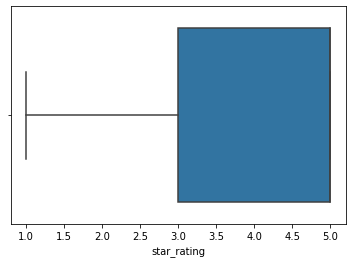

In [10]:
## YOUR EXPLORATORY DATA ANALYSIS CODE HERE ##

sns.boxplot(x = df_clean['star_rating'])

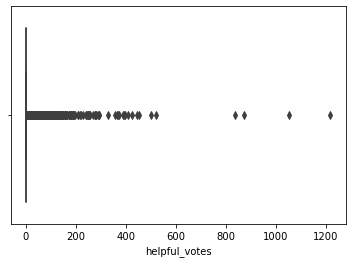

In [11]:
sns.boxplot(x = df_clean['helpful_votes'])

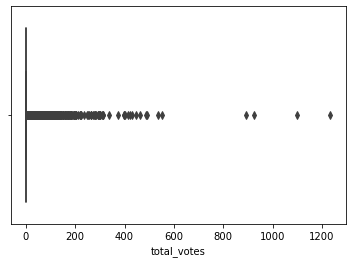

In [12]:
sns.boxplot(x = df_clean['total_votes'])

(array([99569.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   311.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

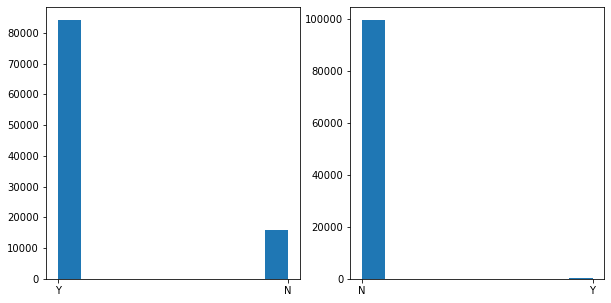

In [13]:
plt.figure(figsize = (10,5))
plt.subplot(1, 2, 1)
plt.hist(df_clean['verified_purchase'])
plt.subplot(1, 2, 2)
plt.hist(df_clean['vine'])

In [14]:
df_clean.corr()

,star_rating,helpful_votes,total_votes
star_rating,1.000000,-0.017211,-0.040931
helpful_votes,-0.017211,1.000000,0.981421
total_votes,-0.040931,0.981421,1.000000


(array([14146.,     0.,  6373.,     0.,     0.,  8482.,     0., 17348.,
            0., 53531.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

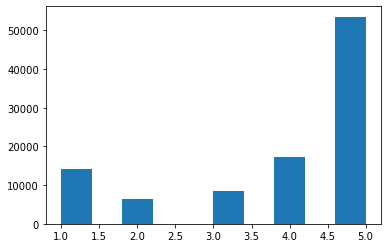

In [18]:
plt.hist(df_clean['star_rating'])

## Part C: Feature Construction

In [19]:
## YOUR FEATURE CONSTRUCTION CODE HERE ##
X = df_clean['review_body']
y = df_clean['star_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [20]:
cv = CountVectorizer()
X_data = cv.fit_transform(X_train)

## Part D: Model Training and Evaluation

In [22]:
## YOUR MODEL TRAINING CODE HERE ##
log_reg = LogisticRegression(solver = 'newton-cg')
log_reg.fit(X_data, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
X_data_cv = cv.transform(X_test)
y_pred = log_reg.predict(X_data_cv)

In [24]:
metrics.accuracy_score(y_test.values, y_pred)

0.6401682018422107

In [25]:
## YOUR MODEL SAVING CODE HERE ##
X_data_final = cv.fit_transform(df_clean['review_body'])
y_data_final = df_clean['star_rating']
log_reg.fit(X_data_final, y_data_final)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
pickle.dump(cv, open('./models/model.pkl', 'wb'))
pickle.dump(log_reg, open('./models/final_model.pkl', 'wb'))

## Part E: Model Deployment

Now we will deploy your model to a local endpoint, test it on some sample data, and then deploy the model to a public endpoint.

In [28]:
## YOUR ENVIRONMENT SETUP CODE HERE ##

import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.model import Model
from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.environment import Environment
from azureml.core.webservice import LocalWebservice

In [29]:
workspace = Workspace.from_config()

In [30]:
final_model = Model.register(workspace = workspace, model_path = './models', model_name = 'final_exam_model')

Registering model final_exam_model


In [56]:
%%writefile ./score.py
## YOUR SCORE.PY CODE HERE ##

import pickle, re, json, os
import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from azureml.core.model import Model


def init():
    global log_reg
    global cv
    model_path  = Model.get_model_path('final_exam_model')
    log_path = os.path.join(model_path, 'final_model.pkl')
    with open(log_path, 'rb') as file:
        log_reg = pickle.load(file)
    cv_path = os.path.join(model_path, 'model.pkl')
    with open(cv_path, 'rb') as file:
        cv = pickle.load(file)
    nltk.download("stopwords", quiet = True)
    nltk.download('punkt')
    nltk.download('wordnet')
    
    
def run(input_data):
    english_stopwords = set(nltk.corpus.stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    input_json = json.loads(input_data)
    review_list = []
    for i in range(input_json['n_reviews']):
        review = input_json['reviews'][i]['review_body']
        text = re.sub('<.*?>', '', review.lower().strip())
        text = re.sub('[^\w\s]', ' ', text)
        result = ''
        tokens = nltk.word_tokenize(text)
        for t in tokens:
            lemma = lemmatizer.lemmatize(t)
            if lemma not in english_stopwords:
                result += lemma + ' '
        review_list.append(result)
    X_data_cv = cv.transform(review_list)
    outputs = log_reg.predict(X_data_cv).tolist()
    response_content = {'predictions': outputs}
    return response_content

Overwriting ./score.py


In [57]:
from azureml.core.conda_dependencies import CondaDependencies 
env_file = CondaDependencies.create(pip_packages = ['azureml-defaults', 'numpy', 'scikit-learn', 'nltk'])
with open('myenv.yml', 'w') as file:
    file.write(env_file.serialize_to_string())

In [58]:
myenv = Environment.from_conda_specification(name = 'myenv', file_path = 'myenv.yml')
inference_config = InferenceConfig(source_directory = '.', entry_script = 'score.py', environment = myenv)
local_deployment_target = LocalWebservice.deploy_configuration(port = 8891)
local_service_model = Model.deploy(
    workspace, 'local-service',
    [final_model], inference_config, 
    local_deployment_target
)
local_service_model.wait_for_deployment(True)

Generating Docker build context.
Package creation Succeeded
Logging into Docker registry ea8294aac11e4bb1a163674f7a1e364a.azurecr.io
Logging into Docker registry ea8294aac11e4bb1a163674f7a1e364a.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM ea8294aac11e4bb1a163674f7a1e364a.azurecr.io/azureml/azureml_b5f85b0874790893b2572168cd390f80
 ---> d414a3caf037
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> a3162d91dca7
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjAwYjcxMGRjLWJiN2ItNGQ3MC1hYWE1LTk3YjY2MjcwMDQyNCIsInJlc291cmNlR3JvdXBOYW1lIjoiZmluYWxleGFtIiwiYWNjb3VudE5hbWUiOiJmaW5hbGV4YW0iLCJ3b3Jrc3BhY2VJZCI6ImVhODI5NGFhLWMxMWUtNGJiMS1hMTYzLTY3NGY3YTFlMzY0YSJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in fbc1a2e12591
 ---> a56a4c5e9fc4
Step 4/5 : RUN mv '/var/azureml-app/tmph32ngkg_.py' /var/azureml-app/main.py
 ---> Running in 6cb169e89550
 ---> 

In [59]:
print(local_service_model.get_logs())

2021-12-12T00:13:55,279339677+00:00 - iot-server/run 
2021-12-12T00:13:55,280273771+00:00 - rsyslog/run 
2021-12-12T00:13:55,282358259+00:00 - gunicorn/run 
2021-12-12T00:13:55,282617657+00:00 - nginx/run 
Dynamic Python package installation is disabled.
Starting HTTP server
EdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...
2021-12-12T00:13:55,362865165+00:00 - iot-server/finish 1 0
2021-12-12T00:13:55,364135457+00:00 - Exit code 1 is normal. Not restarting iot-server.
Starting gunicorn 20.1.0
Listening at: http://127.0.0.1:31311 (14)
Using worker: sync
worker timeout is set to 300
Booting worker with pid: 43
SPARK_HOME not set. Skipping PySpark Initialization.
Initializing logger
2021-12-12 00:13:57,018 | root | INFO | Starting up app insights client
logging socket was found. logging is available.
logging socket was found. logging is available.
2021-12-12 00:13:57,019 | root | INFO | Starting up request id generator
2021-12-12 00:13:57,019 | root | INFO | Star

In [60]:
example_json = json.dumps({
    "n_reviews" : 2,
    "reviews" : [
        {
            "marketplace" : "US",
            "customer_id" : "20422322",
            "review_id" : "R8MEA6IGAHO0B",
            "product_id" : "B00MC4CED8",
            "product_parent" : "217304173",
            "product_title" : "BlackVue",
            "product_category" : "Mobile_Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Very Happy!    As advertised.",
            "review_body" : "Everything works perfectly, I'm happy",
            "review_date" : "2015-08-31"
        },
        {
            "marketplace" : "US",
            "customer_id" : "15204307",
            "review_id" : "RZGDLDMGMGKLB",
            "product_id" : "B000I3F91O",
            "product_parent" : "90621845",
            "product_title" : "Sangean H205 AM/FM Weather Alert Waterproof",
            "product_category" : "Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Best shower radio I have ever owned",
            "review_body" : "love shower radio own shower radio best one",
            "review_date" : "2014-11-08"
        },
    ]
})
example_json = bytes(example_json, encoding = "utf8")
output = local_service_model.run(example_json)
print(output)

{'predictions': [5, 5]}


Once our local service is ready, we can now deploy it to a public endpoint. While creating an `AciWebservice,` I have set `cpu_cores=3.8` and `memory_gb=15` to maximize the processing power in the deployment environment.

If Azure complains that the specified specs are too high, you can check the specific upper bounds for your region [here](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-region-availability).

In [61]:
aci_deployment_config = AciWebservice.deploy_configuration(
    cpu_cores = 3.8, memory_gb = 15)

model_aci_service = Model.deploy(
    workspace, "model-aci-service-5",
    [final_model], inference_config, 
    aci_deployment_config
)

model_aci_service.wait_for_deployment(True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-12-12 00:14:47+00:00 Creating Container Registry if not exists.
2021-12-12 00:14:47+00:00 Registering the environment.
2021-12-12 00:14:47+00:00 Use the existing image.
2021-12-12 00:14:47+00:00 Generating deployment configuration.
2021-12-12 00:14:48+00:00 Submitting deployment to compute.
2021-12-12 00:14:54+00:00 Checking the status of deployment model-aci-service-5..
2021-12-12 00:17:10+00:00 Checking the status of inference endpoint model-aci-service-5.
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [62]:
## YOUR SCORING_URI CODE HERE ##
deployed_uri = model_aci_service.scoring_uri
with open('scoring_uri.txt', 'w') as file:
    file.write(deployed_uri)

In [63]:
def ping_endpoint(json_data, uri = None):
    if uri is None:
        uri = open("scoring_uri.txt", "r").read()
    headers = {'Content-Type' : 'application/json'}
    response = requests.post(uri, json_data, headers = headers)
    return response.status_code, response.text

Let's test our model on the provided `example_json`. Check that the status code is 200 and the predicted labels are what we expect.

In [64]:
# test the deployed model with 2 samples
status_code, predicted_labels = ping_endpoint(example_json)
print(status_code)
print(predicted_labels)

200
{"predictions": [5, 5]}


Now we can test your model on a 5000-row subset of the training dataset. Again check that the status code is 200 and the predict labels are a list of 5000 integers. If you encounter any error, check your `service.get_logs()`. One common issue is that the request times out; in other words, your deployed model takes too long to process the test data and generate predictions. To address this, you would need to optimize your data processing steps and redeploy them. Our grader will also send 5000 rows of test data to your endpoint in one single request.

**Notes**:
* Azure ACI enforces a one-minute timeout for handling the input request. If your code takes longer than one minute, the endpoint will return a 502 or 504 error.

In [65]:
from sklearn.metrics import accuracy_score

def construct_json_input():
    df_training_subset = read_data().sample(n = 5000, random_state = 200)
    true_labels = df_training_subset["star_rating"]
    training_subset_json = json.dumps({
        "n_reviews" : len(df_training_subset),
        "reviews" : df_training_subset.drop(columns = "star_rating").to_dict("records")
    })
    return bytes(training_subset_json, encoding = "utf8"), true_labels

# test the deployed model with a subset of training data
def test_model_deployment():
    data, true_labels = construct_json_input()
    status_code, response = ping_endpoint(data)
    print("Status code", status_code)
    predicted_labels = json.loads(response)["predictions"]
    print("Model accuracy", accuracy_score(true_labels, predicted_labels))
    
test_model_deployment()

Status code 200
Model accuracy 0.8096
